In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.utils import convert_kstar_evol_type
from cosmic.plotting import evolve_and_plot

import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Helper functions and variables for unit conversions

def aui_to_porb(aui, m_tot):
    # aui: a list of values, initial separation in AU
    # m_tot: a list of values, total mass in M_sun
    # result: a list of values, orbital period in given condition in days
    res = []
    for i in range(len(aui)):
        res.append((1/m_tot[i]**0.5) * (aui[i]**1.5) * 365)
    return res

# Used to convert separation in R_sun into AU
unit_factor = 1 / 215.032

# Helper function: given an array of data and an array of target,
# return an array of index that is nearest to the target value.
import math 
def findNearestList(data, targetList):
    res = []
    for num in targetList:
        res.append(findNearest(data, num))
    return res

def findNearest(data, target):
    n = len(data)
    res = -1
    minDiff = 10**5
    for i in range(n):
        if data[i] == 10**(-5):
            continue
        if abs(target - data[i]) <= minDiff:
            res = i
            minDiff = abs(target - data[i])
    return res

In [3]:
# Default BSEDict with modified qcrit_array
# force stable mass transfer
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 0, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : 0.1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [4]:
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 0.7
MASS_TOT = 7.7

ECC = 0

SEP_START = 2
SEP_END = 8

SOLAR_MET = 0.02

TPHYS_LIM = 20000

In [5]:
BSEDict['acc_lim'] = 0.1

In [6]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [7]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [8]:
data2 = np.zeros(NUM_SEP)
data4 = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    # print(single_bpp[['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep in AU', 'evol_type']])
    
    # cond1 = (single_bpp['evol_type'] == 4)
    cond2 = (single_bpp['kstar_1'] <= 12) 
    cond3 = (single_bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (single_bpp['kstar_2'] <= 1)
    cond5 = (single_bpp['kstar_2'] >= 0) # Select kstar_2 to be MS
    # cond2 = (single_bpp['evol_type']==8)
    
    specific_rows = single_bpp[(cond2) & (cond3) & (cond4) & (cond5)]
    if (len(specific_rows) > 0):
        row = specific_rows.iloc[0]
        data2[i] = row['sep in AU']
        data4[i] = row['mass_2']
    else: data2[i] = -1

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 821.70it/s]


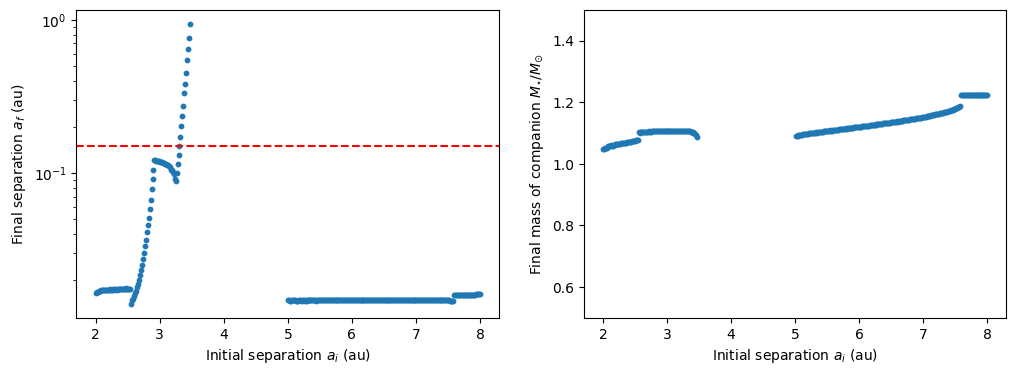

In [9]:
# Create the plot
newlist1 = []
newsep1 = []
newmass1 = []
for i in range(len(ai_list)):
    if data2[i] != -1:
        newlist1.append(ai_list[i])
        newsep1.append(data2[i])
        newmass1.append(data4[i])
        
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(newlist1, newsep1, s=10)
axs[0].axhline(y=0.15, color='red', linestyle='--')

# Add titles and labels
axs[0].set_xlabel(r'Initial separation $a_i$ (au)')
axs[0].set_ylabel(r'Final separation $a_f$ (au)')
axs[0].set_yscale('log')

axs[1].scatter(newlist1, newmass1, s=10)
axs[1].set_xlabel(r'Initial separation $a_i$ (au)')
axs[1].set_ylabel(r'Final mass of companion $M_{\star}/M_{\odot}$')
axs[1].set_ylim(0.5,1.5)

# Show the plot
plt.show()

In [10]:
NUM_SEP = 400

MASS_1 = 7
MASS_2 = 0.5
MASS_TOT = MASS_1 + MASS_2

ECC = 0

SEP_START = 2
SEP_END = 8

SOLAR_MET = 0.02

TPHYS_LIM = 20000

In [11]:
BSEDict['acc_lim'] = 0.2

In [12]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [13]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [14]:
data3 = np.zeros(NUM_SEP)
data5 = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    # print(single_bpp[['tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep in AU', 'evol_type']])
    
    # cond1 = (single_bpp['evol_type'] == 4)
    cond2 = (single_bpp['kstar_1'] <= 12) 
    cond3 = (single_bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (single_bpp['kstar_2'] <= 1)
    cond5 = (single_bpp['kstar_2'] >= 0) # Select kstar_2 to be MS
    # cond2 = (single_bpp['evol_type']==8)
    
    specific_rows = single_bpp[(cond2) & (cond3) & (cond4) & (cond5)]
    if (len(specific_rows) > 0):
        row = specific_rows.iloc[0]
        data3[i] = row['sep in AU']
        data5[i] = row['mass_2']
    else: data3[i] = -1

100%|████████████████████████████████████████| 400/400 [00:00<00:00, 708.96it/s]


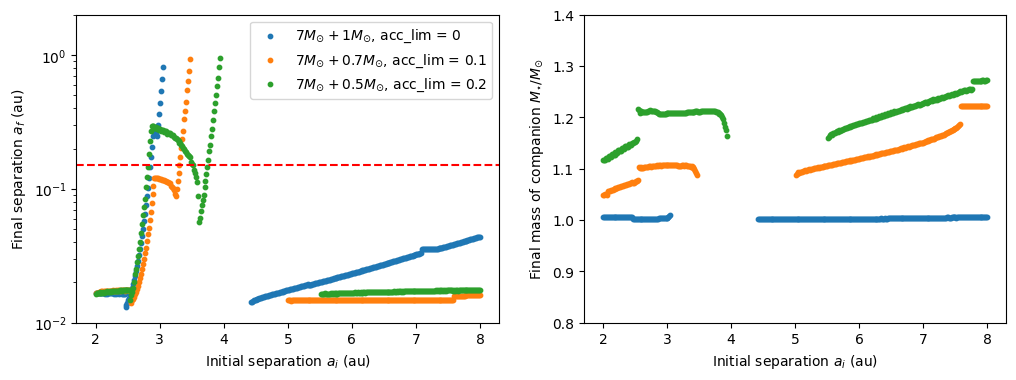

In [41]:
# Create the plot
newlist2 = []
newsep2 = []
newmass2 = []
newlist3 = [2.0, 2.0150375939849625, 2.030075187969925, 2.045112781954887, 2.0601503759398496, 2.075187969924812, 2.090225563909774, 2.1052631578947367, 2.1203007518796992, 2.1353383458646618, 2.1503759398496243, 2.1654135338345863, 2.180451127819549, 2.1954887218045114, 2.2105263157894735, 2.225563909774436, 2.2406015037593985, 2.255639097744361, 2.2706766917293235, 2.2857142857142856, 2.300751879699248, 2.3157894736842106, 2.3308270676691727, 2.345864661654135, 2.3609022556390977, 2.3759398496240602, 2.3909774436090228, 2.406015037593985, 2.4210526315789473, 2.43609022556391, 2.451127819548872, 2.4661654135338344, 2.481203007518797, 2.4962406015037595, 2.511278195488722, 2.526315789473684, 2.5413533834586466, 2.556390977443609, 2.571428571428571, 2.5864661654135337, 2.601503759398496, 2.6165413533834587, 2.6315789473684212, 2.6466165413533833, 2.661654135338346, 2.6766917293233083, 2.6917293233082704, 2.706766917293233, 2.7218045112781954, 2.736842105263158, 2.7518796992481205, 2.7669172932330826, 2.781954887218045, 2.7969924812030076, 2.8120300751879697, 2.827067669172932, 2.8421052631578947, 2.857142857142857, 2.8721804511278197, 2.887218045112782, 2.9022556390977443, 2.917293233082707, 2.932330827067669, 2.9473684210526314, 2.962406015037594, 2.9774436090225564, 2.992481203007519, 3.007518796992481, 3.0225563909774436, 3.037593984962406, 3.052631578947368, 4.421052631578947, 4.43609022556391, 4.451127819548872, 4.466165413533835, 4.481203007518797, 4.496240601503759, 4.511278195488721, 4.526315789473684, 4.541353383458647, 4.556390977443609, 4.571428571428571, 4.586466165413533, 4.601503759398496, 4.616541353383458, 4.631578947368421, 4.646616541353383, 4.661654135338345, 4.676691729323308, 4.69172932330827, 4.706766917293233, 4.7218045112781954, 4.7368421052631575, 4.75187969924812, 4.7669172932330826, 4.7819548872180455, 4.796992481203008, 4.81203007518797, 4.827067669172932, 4.842105263157895, 4.857142857142857, 4.87218045112782, 4.887218045112782, 4.902255639097744, 4.917293233082707, 4.932330827067669, 4.947368421052632, 4.962406015037594, 4.977443609022556, 4.992481203007518, 5.007518796992481, 5.022556390977444, 5.037593984962406, 5.052631578947368, 5.06766917293233, 5.082706766917293, 5.097744360902255, 5.112781954887218, 5.12781954887218, 5.142857142857142, 5.157894736842105, 5.172932330827067, 5.18796992481203, 5.203007518796992, 5.2180451127819545, 5.233082706766917, 5.2481203007518795, 5.2631578947368425, 5.2781954887218046, 5.293233082706767, 5.308270676691729, 5.323308270676692, 5.338345864661654, 5.353383458646617, 5.368421052631579, 5.383458646616541, 5.398496240601504, 5.413533834586466, 5.428571428571429, 5.443609022556391, 5.458646616541353, 5.473684210526315, 5.488721804511278, 5.503759398496241, 5.518796992481203, 5.533834586466165, 5.548872180451127, 5.56390977443609, 5.578947368421052, 5.593984962406015, 5.609022556390977, 5.624060150375939, 5.639097744360902, 5.654135338345864, 5.669172932330827, 5.684210526315789, 5.6992481203007515, 5.7142857142857135, 5.7293233082706765, 5.7443609022556394, 5.7593984962406015, 5.774436090225564, 5.789473684210526, 5.804511278195489, 5.819548872180451, 5.834586466165414, 5.849624060150376, 5.864661654135338, 5.879699248120301, 5.894736842105263, 5.909774436090226, 5.924812030075188, 5.93984962406015, 5.954887218045112, 5.969924812030075, 5.984962406015038, 6.0, 6.015037593984962, 6.030075187969924, 6.045112781954887, 6.060150375939849, 6.075187969924812, 6.090225563909774, 6.105263157894736, 6.120300751879699, 6.135338345864661, 6.150375939849624, 6.165413533834586, 6.180451127819548, 6.195488721804511, 6.2105263157894735, 6.2255639097744355, 6.2406015037593985, 6.2556390977443606, 6.270676691729323, 6.285714285714286, 6.300751879699248, 6.315789473684211, 6.330827067669173, 6.345864661654135, 6.360902255639098, 6.37593984962406, 6.390977443609023, 6.406015037593985, 6.421052631578947, 6.43609022556391, 6.451127819548872, 6.466165413533834, 6.481203007518797, 6.496240601503759, 6.511278195488721, 6.526315789473684, 6.541353383458646, 6.556390977443609, 6.571428571428571, 6.586466165413533, 6.601503759398496, 6.616541353383458, 6.631578947368421, 6.646616541353383, 6.661654135338345, 6.676691729323308, 6.69172932330827, 6.7067669172932325, 6.7218045112781954, 6.7368421052631575, 6.75187969924812, 6.7669172932330826, 6.781954887218045, 6.796992481203008, 6.81203007518797, 6.827067669172932, 6.842105263157895, 6.857142857142857, 6.87218045112782, 6.887218045112782, 6.902255639097744, 6.917293233082707, 6.932330827067669, 6.947368421052631, 6.962406015037594, 6.977443609022556, 6.992481203007518, 7.007518796992481, 7.022556390977443, 7.037593984962406, 7.052631578947368, 7.06766917293233, 7.082706766917293, 7.097744360902255, 7.112781954887218, 7.12781954887218, 7.142857142857142, 7.157894736842105, 7.172932330827067, 7.1879699248120295, 7.203007518796992, 7.2180451127819545, 7.233082706766917, 7.2481203007518795, 7.263157894736842, 7.2781954887218046, 7.293233082706767, 7.308270676691729, 7.323308270676692, 7.338345864661654, 7.353383458646617, 7.368421052631579, 7.383458646616541, 7.398496240601504, 7.413533834586466, 7.428571428571428, 7.443609022556391, 7.458646616541353, 7.473684210526315, 7.488721804511278, 7.50375939849624, 7.518796992481203, 7.533834586466165, 7.548872180451127, 7.56390977443609, 7.578947368421052, 7.593984962406015, 7.609022556390977, 7.624060150375939, 7.639097744360902, 7.654135338345864, 7.669172932330826, 7.684210526315789, 7.6992481203007515, 7.7142857142857135, 7.7293233082706765, 7.744360902255639, 7.7593984962406015, 7.774436090225564, 7.789473684210526, 7.804511278195489, 7.819548872180451, 7.834586466165414, 7.849624060150376, 7.864661654135338, 7.879699248120301, 7.894736842105263, 7.909774436090225, 7.924812030075188, 7.93984962406015, 7.954887218045112, 7.969924812030075, 7.984962406015037, 8.0]
newsep3 = [0.016618033619372995, 0.01676358218905962, 0.01664885781037645, 0.016536684975947027, 0.016678111548013446, 0.01656637857351303, 0.016702866682140948, 0.01658896181808216, 0.01672516924933869, 0.016611540588571786, 0.016499279307713003, 0.01663259890998787, 0.016520772599210008, 0.016652757398179716, 0.01654125992969691, 0.016675334423897955, 0.016564766892023144, 0.016696672179287775, 0.01658814798569546, 0.01648301534079813, 0.01661791403393328, 0.016513940764877978, 0.016650877379974203, 0.01655735588739752, 0.016470704355667908, 0.016616076414174775, 0.016542002275299623, 0.016476430546927056, 0.016432375294692648, 0.016467521052319495, 0.01643814360306812, 0.013032851714618291, 0.013463411217512405, 0.014078490863778888, 0.014668111115985628, 0.015411025466574994, 0.01621522273571276, 0.01710738336126466, 0.01819869896862347, 0.019372468281031913, 0.020692227750566016, 0.02241137006686007, 0.02423613425964232, 0.02643642402033954, 0.02885745215823048, 0.03180630643053004, 0.03528445791276153, 0.039549448006455074, 0.044588524867319394, 0.050020980693179416, 0.05708332196910653, 0.06545342118270735, 0.07570645893777146, 0.0882888826856771, 0.10195360904626058, 0.12007943339124298, 0.144656212542375, 0.17355998499470318, 0.2065145690526712, 0.2502791218853216, 0.2739817071533887, 0.26644883032025013, 0.26330417523926647, 0.2562054066501511, 0.24725360088266077, 0.29900967567868897, 0.36411194190614715, 0.4367988551588697, 0.5365531539641906, 0.664630418943799, 0.8105355507093831, 0.014174499286815826, 0.014380522529804533, 0.014542781596851583, 0.014665778494975752, 0.01477973185819144, 0.014879546473623998, 0.014974545088344969, 0.015060193454698728, 0.015147316042289048, 0.015230787091100387, 0.015312776690196803, 0.015395299756629326, 0.015478141847121011, 0.015553070671233876, 0.015636168338205508, 0.015709943660256975, 0.015787723205457186, 0.015868516757954552, 0.01594170031791427, 0.016020698177789044, 0.016100311445381356, 0.01617593029941385, 0.016250672131462814, 0.016327440226720738, 0.01640435434167957, 0.016485563126683103, 0.016562568886194284, 0.016637651272732125, 0.01671599169186705, 0.016793240337407728, 0.016870998159536372, 0.016947949452932973, 0.017028450126272656, 0.017104653467919815, 0.017181480741234448, 0.017258766594879897, 0.017336627296754493, 0.017416859034307414, 0.017495637273793798, 0.017573054554975362, 0.017651176362989657, 0.017730202396927564, 0.017809694325046296, 0.017890476093621814, 0.017975170807544207, 0.018054676413479808, 0.018133191467523593, 0.018208262143511823, 0.018290983473502925, 0.018382710327796842, 0.018472544285673135, 0.018563078614222184, 0.018652984678671033, 0.018745050198429803, 0.018838968414604678, 0.01893647609148931, 0.019035744078771705, 0.01913792606702028, 0.019249762804591935, 0.01936729053668792, 0.018982889155801052, 0.019078597444400214, 0.019172854080192217, 0.019266918751305033, 0.01936186452805438, 0.01945501660394466, 0.01954888848089411, 0.019643605541676552, 0.019721837489981898, 0.019816426057639096, 0.019904788636532805, 0.019995928997762098, 0.0200842466718246, 0.02017416643975591, 0.020266124468366408, 0.020357366635227293, 0.020449396872920664, 0.020548235903004617, 0.020641645912153644, 0.020735318709790177, 0.02082869504546123, 0.020922545181733188, 0.02101634979056205, 0.02111134494541923, 0.021207029907883, 0.02131031841504287, 0.02140498334091916, 0.02150283320367703, 0.021599184626855273, 0.02169641277538106, 0.02179464602525117, 0.02189235646268869, 0.021999941602528498, 0.02209986372188354, 0.02219949857112402, 0.02229902472465696, 0.022399987351235502, 0.0225008437963239, 0.02261087966115076, 0.02271627929561699, 0.022818917933933244, 0.022922471183663196, 0.023026669013218717, 0.023129158583192408, 0.023243644604365992, 0.023351881500657708, 0.023460209669357964, 0.023568681110095677, 0.02367461888607472, 0.023790702623419036, 0.023901488904934577, 0.02401192333363247, 0.024124071786437835, 0.024236051633352344, 0.024357956180050173, 0.024471508194785836, 0.024584930948664124, 0.02469990834411867, 0.02481258132732856, 0.02493797636990872, 0.02505779597247138, 0.025177713602332674, 0.02529642638394481, 0.02541246892525737, 0.025541876101339057, 0.02566363411936161, 0.025786354591511112, 0.025908016037496335, 0.02602976620451991, 0.02616831001138643, 0.026294543539945755, 0.026418390475912587, 0.026541666718520172, 0.026679883037818035, 0.026810108535834556, 0.026940222965123883, 0.027069336848578013, 0.027199675681181097, 0.02734447777340118, 0.027477273049067632, 0.027608109907602447, 0.027738573992564367, 0.027886292989223106, 0.02802491661666974, 0.028161988684028923, 0.0282980143931746, 0.028433924513882745, 0.0285875461653497, 0.028726643960743967, 0.02886388404670037, 0.02900354500943982, 0.02916060532465996, 0.02930654755315841, 0.029450422940144282, 0.02959394799032978, 0.029733405171714064, 0.029896300819842805, 0.030042491996513727, 0.030186676451809367, 0.03033322641766201, 0.0304996471945772, 0.030652790587055136, 0.030803282633026396, 0.030950215808244752, 0.03109820226460978, 0.03126835084757332, 0.0314222308091124, 0.03156019324568165, 0.0317346276918706, 0.03189384317871717, 0.032050078037263854, 0.03220066913921157, 0.03235777537455367, 0.03251355998789048, 0.032683077191137264, 0.03281230231266963, 0.032922522081063804, 0.033024818930336555, 0.03552698964108578, 0.03556133444167865, 0.03556508510335102, 0.03556937327200776, 0.03557469624073397, 0.03558070170717447, 0.035586765210580656, 0.035580438687052254, 0.035589320089221485, 0.03560753789715867, 0.03564969330920694, 0.03566214824635667, 0.03567603852786604, 0.03569139794079077, 0.03570778818543757, 0.035758300275321, 0.03581505389016163, 0.035887617451607096, 0.035957834022272685, 0.036080030711992804, 0.036207110397794603, 0.036377876074577854, 0.03654607887641037, 0.03669775260067888, 0.03687913692906854, 0.037064088502207125, 0.03724745795216058, 0.03743374866389199, 0.03762023038895693, 0.03777447344989594, 0.03796816969078717, 0.038160468381222216, 0.03835080694075919, 0.038544247168905, 0.03873865208854454, 0.038931062190670405, 0.03909535421861278, 0.039294210037271744, 0.039493848254286076, 0.039691195512058304, 0.03989152348728289, 0.04009231922801023, 0.04026085196961765, 0.04046382202230713, 0.040671245009186126, 0.04087859130950172, 0.04108860719700606, 0.04129298205076395, 0.04150018776244611, 0.04167442856510943, 0.04189218579797385, 0.04210213078130137, 0.042316845075128146, 0.04253316650393505, 0.04274640939310666, 0.042959823390803925, 0.04313937980774161, 0.043369880429271826, 0.043586187189306694, 0.0438087369861119, 0.04403320007405652]
newmass3 = [1.0053513108980847, 1.0053290680301779, 1.0053483292437948, 1.005366652746554, 1.0053459017276882, 1.0053642205271585, 1.0053444963642753, 1.0053632357138806, 1.0053438470983544, 1.0053627150208104, 1.005382418442812, 1.0053630591478717, 1.0053833480684113, 1.0053643434927617, 1.0053855990884981, 1.005366476782713, 1.005389017592768, 1.005370464516488, 1.0053950217882293, 1.0054184216384898, 1.0054029368297044, 1.0054237215948891, 1.0054079707262882, 1.005431405852667, 1.0054524012848203, 1.0054386385583407, 1.0054633238496118, 1.0054930322548612, 1.005518770312473, 1.0055373832876529, 1.0055763392949373, 1.0029471507283847, 1.0024354138836176, 1.0021829662567632, 1.0020644116670576, 1.0020002577680156, 1.0019965641872721, 1.001959988107802, 1.0019173828438295, 1.0018838555333098, 1.0018695546002605, 1.001871336041081, 1.001949973947566, 1.0018653175256935, 1.0018694510574102, 1.001949511559759, 1.0019355342632341, 1.0019222796793321, 1.00195757938798, 1.0020581207385633, 1.0020412489467352, 1.002173042077259, 1.0021817686164205, 1.0023520081567903, 1.0023561874664695, 1.0025685327391307, 1.0026950069293987, 1.0028704873235919, 1.0030326085097931, 1.00334471802831, 1.0034702410374454, 1.003459362745963, 1.0034263164752397, 1.0033468649788202, 1.0033216687035678, 1.0036765389373494, 1.0041974490579733, 1.0048617007827976, 1.0059993064782884, 1.0075751506919246, 1.0095373844089586, 1.0015733207834985, 1.0016447957717662, 1.001582527792404, 1.001640785803275, 1.001589924274624, 1.001611632821484, 1.001606545056387, 1.0016507385980955, 1.0016778118382683, 1.0016800187999029, 1.001665298355588, 1.001630705680773, 1.00161508818917, 1.001664011409794, 1.0016230761458673, 1.0016604045005102, 1.0017122741925977, 1.0016401283715808, 1.0016805793786974, 1.0017190866249996, 1.0016423489059052, 1.001657755840383, 1.001698402247022, 1.0017265844820256, 1.0017502679346988, 1.001659503439302, 1.0016709665578303, 1.0017026597499485, 1.0017262831700509, 1.0017478292430266, 1.0017673732136336, 1.0017848945268426, 1.0016834578113099, 1.0016935097498132, 1.00170335310832, 1.0017243776859128, 1.0017451928247485, 1.0017659352621209, 1.0017835133005046, 1.0017983616967643, 1.0018113615490534, 1.001824601727039, 1.0018400030950043, 1.0018569329044955, 1.001741298172286, 1.0017519204689904, 1.0017701980626879, 1.00178885621606, 1.00180772007618, 1.0018289979231538, 1.0018450624661874, 1.0018594096698294, 1.0018733557009674, 1.0018904829314077, 1.0019069743212672, 1.0019240897710442, 1.0019386632727967, 1.0019519126123315, 1.0018289074076303, 1.001853873063782, 1.0018772473717514, 1.001902857128088, 1.001925125341866, 1.0019441151049033, 1.001965069940698, 1.0019859785994554, 1.0020052621221087, 1.0020243440927208, 1.0020556294990108, 1.0019231193202998, 1.0019555023228992, 1.0019866642024846, 1.0020139714346512, 1.0020389122406002, 1.002063366060591, 1.00208616341835, 1.0021095363679564, 1.0019860241998133, 1.0020199114224582, 1.0020519876432759, 1.0020863687054697, 1.002119864850671, 1.0021477797491192, 1.002173656713828, 1.0022122286986506, 1.002079870766402, 1.002122032639021, 1.0021624849127018, 1.0021957200613794, 1.002225706015445, 1.0022591762530244, 1.0023208468202798, 1.0021753887844125, 1.0022170549764564, 1.002261437857497, 1.0023003716067882, 1.0023352610231366, 1.0023955442943142, 1.0022492568320203, 1.0023033592911308, 1.0023490671563657, 1.0023892149345464, 1.0024291518485757, 1.0025129686107073, 1.002354861939803, 1.0024051736767317, 1.0024546702527235, 1.0025012938687312, 1.0025843181545957, 1.002420851978343, 1.002479902741493, 1.002534771540553, 1.002582592198874, 1.0026656993418932, 1.0025123429151286, 1.002573292305726, 1.0026263910437057, 1.0026774509834675, 1.0027851141535262, 1.0026112787171904, 1.0026716717129065, 1.0027353663976624, 1.002822653308602, 1.0029132462238366, 1.002725506663009, 1.0027931789544087, 1.0028517837847186, 1.0029600869581945, 1.0030583479843405, 1.0028583398448414, 1.0029199538339348, 1.0030219493232815, 1.0031291755653426, 1.0029220012481985, 1.0029912071818312, 1.0030805850809295, 1.003201643306094, 1.003287612983939, 1.0030714425752825, 1.0031394197946784, 1.003266349473312, 1.003374869581258, 1.0031490210630332, 1.0032192258029204, 1.003343840477484, 1.003465160857544, 1.0035478879012816, 1.003302074806784, 1.0034151880167452, 1.003543909304839, 1.0036352424120658, 1.0033886927873237, 1.0034767130013718, 1.0036179533578538, 1.0037341267312725, 1.003816545281971, 1.0035459371497304, 1.0036828165420582, 1.0038165568090671, 1.0039097055721913, 1.0036264862967663, 1.0037443777267874, 1.0038926051724228, 1.0039943672378984, 1.0040816441751028, 1.0037876323982955, 1.0039366997442898, 1.0041673064868388, 1.003860079977171, 1.0039878122984596, 1.0041364330861677, 1.0042662030418088, 1.0042716574084405, 1.0043499574082169, 1.0040273601466132, 1.0041328174220217, 1.0043142301652863, 1.0044058200947454, 1.0048862519209047, 1.0048745554800147, 1.0048405569765009, 1.00480479196257, 1.0047666128342898, 1.0047236882295294, 1.0046752642299066, 1.0046219541372339, 1.0049581119308102, 1.004944036728149, 1.0049410698376358, 1.0049145265727442, 1.00488182066731, 1.004840470772331, 1.0049652297791491, 1.0049447514806271, 1.0049174023592597, 1.0048905074172523, 1.0050085255431758, 1.0049807904342802, 1.004931301806126, 1.0048175321786796, 1.0047152538298383, 1.0051498011241982, 1.0051381771256138, 1.0051122244430202, 1.005101656867044, 1.0050417239012375, 1.0049105413117847, 1.0053949364377703, 1.0053568940130302, 1.0053372074526243, 1.005334429408856, 1.0052848542668698, 1.0052061287960985, 1.0051365496137206, 1.0055875341011953, 1.0055637536578468, 1.0055413491925658, 1.0055356517834924, 1.0054842430168085, 1.00540697504394, 1.0058114146133268, 1.00581498462015, 1.0057827204791612, 1.0057542983154713, 1.005696224461813, 1.0056815166025797, 1.005589343976349, 1.006036824072508, 1.0059969812534673, 1.0059905629055506, 1.0059593790735954, 1.0059067488604956, 1.0058804797441034, 1.0057899397502688, 1.0062672972731526, 1.0061977525794834, 1.0062110516819585, 1.0061721723709252, 1.006108435388302]

for i in range(len(ai_list)):
    if data3[i] != -1:
        newlist2.append(ai_list[i])
        newsep2.append(data3[i])
        newmass2.append(data5[i])
        
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].scatter(newlist3, newsep3, s=10, label = r'$7 M_{\odot} + 1 M_{\odot}$, acc_lim = 0')
axs[0].scatter(newlist1, newsep1, s=10, label = r'$7 M_{\odot} + 0.7 M_{\odot}$, acc_lim = 0.1')
axs[0].scatter(newlist2, newsep2, s=10, label = r'$7 M_{\odot} + 0.5 M_{\odot}$, acc_lim = 0.2')
axs[0].axhline(y=0.15, color='red', linestyle='--')

# Add titles and labels
axs[0].set_xlabel(r'Initial separation $a_i$ (au)')
axs[0].set_ylabel(r'Final separation $a_f$ (au)')
axs[0].set_yscale('log')
axs[0].set_ylim(0.01,2)

axs[1].scatter(newlist3, newmass3, s=10, label = r'$7 M_{\odot} + 1 M_{\odot}$, acc_lim = 0')
axs[1].scatter(newlist1, newmass1, s=10, label = r'$7 M_{\odot} + 0.7 M_{\odot}$, acc_lim = 0.1')
axs[1].scatter(newlist2, newmass2, s=10, label = r'$7 M_{\odot} + 0.5 M_{\odot}$, acc_lim = 0.2')
axs[1].set_xlabel(r'Initial separation $a_i$ (au)')
axs[1].set_ylabel(r'Final mass of companion $M_{\star}/M_{\odot}$')
axs[1].set_ylim(0.8,1.4)

axs[0].legend(loc='upper right')

# Show the plot
plt.savefig('stable7+1ex.png', dpi=300)
plt.show()